# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


database = '../data/IoT.db'
# database = '../data/TinyVul.db'
# database = "/Users/guru/research/TinyVul.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

In [35]:
dfs.cwe.value_counts()

Benign        2652
Vulnerable     321
Name: cwe, dtype: int64

In [34]:
dff.cwe.value_counts()

Benign         1204
Vulnerable      125
CWE-unknown      28
Name: cwe, dtype: int64

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [8]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfplt, 
    path=['category', 'name', 'cwe'], 
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [9]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,name,cwe,count
2,buffer,char,CWE-119!/CWE-120,61
8,fixed size global buffer,-,CWE-unknown,40
12,snprintf,-,CWE-unknown,37
11,memcpy,-,CWE-unknown,28
3,buffer,memcpy,CWE-120,24
6,buffer,strlen,CWE-126,24
14,strlen,-,CWE-unknown,24
4,buffer,sprintf,CWE-120,18
7,buffer,strncpy,CWE-120,18
15,strncpy,-,CWE-unknown,18


# Top 10 vulnerabilities

In [10]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+--------------------------+---------+------------------+---------+
|    | category                 | name    | cwe              |   count |
|----+--------------------------+---------+------------------+---------|
|  0 | buffer                   | char    | CWE-119!/CWE-120 |      61 |
|  1 | fixed size global buffer | -       | CWE-unknown      |      40 |
|  2 | snprintf                 | -       | CWE-unknown      |      37 |
|  3 | memcpy                   | -       | CWE-unknown      |      28 |
|  4 | buffer                   | memcpy  | CWE-120          |      24 |
|  5 | buffer                   | strlen  | CWE-126          |      24 |
|  6 | strlen                   | -       | CWE-unknown      |      24 |
|  7 | buffer                   | sprintf | CWE-120          |      18 |
|  8 | buffer                   | strncpy | CWE-120          |      18 |
|  9 | strncpy                  | -       | CWE-unknown      |      18 |
+----+--------------------------+---------+--------

<AxesSubplot: >

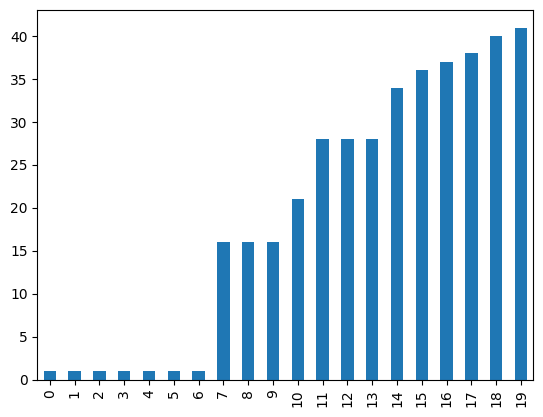

In [11]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [12]:
dfs.context

0          static char server[MAX_SERVERLEN + 1];
1              static char nick[MAX_NICKLEN + 1];
2         char buf1[MAX_NICKLEN + MAX_SERVERLEN];
3             strncpy(buf1, text1, sizeof(buf1));
4                             len = strlen(buf1);
                          ...                    
2968                                     } else {
2969                               if(!sending) {
2970                            char buf[BUFLEN];
2971                                            -
2972                                            -
Name: context, Length: 2973, dtype: object

<AxesSubplot: ylabel='Frequency'>

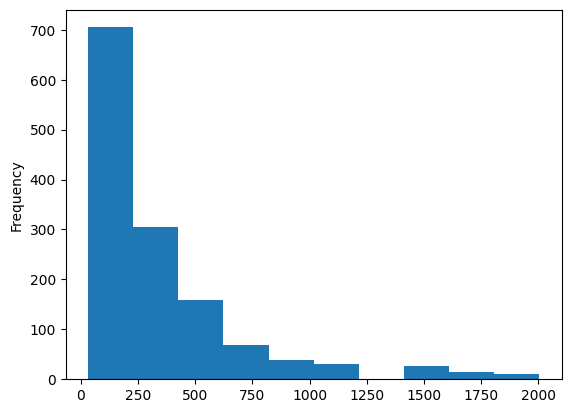

In [13]:
pd.Series([len(x) for x in dff.code if len(x)>10]).plot.hist(xlabel='#chars', ylabel='#statements')

In [14]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[41, 30, 64, 4, 46]

In [15]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

# Convert hyperparameters list to latex table format

In [16]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
  debug\_epochs &                               3 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [17]:
# for project-wise distribution
projects = list(dfs.project.unique())

for project in projects:
    print(project)
    df = dfs[dfs.project == project]
    print(df.shape)
    print(df.cwe.value_counts())
    print(df.category.value_counts())
    print('----------------------')

data/projects/contiki-2.4/apps/shell/
(2973, 16)
Benign              2652
CWE-unknown          161
CWE-120               62
CWE-119!/CWE-120      61
CWE-126               24
CWE-134               13
Name: cwe, dtype: int64
buffer                      147
fixed size global buffer     40
snprintf                     37
memcpy                       28
strlen                       24
strncpy                      18
format                       13
Static Global Buffer         11
-                             2
sprintf                       1
Name: category, dtype: int64
----------------------


## Create a latex table from the statistics of projects

In [18]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs.loc[dfs.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs['project'] = dfs.project.str.split('/').str[-1]

prj_stat = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))
prj_s

count
project cwe              
        Benign       2652
        Vulnerable    321

In [19]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [20]:
# make class binary type benign/vulnerable
dff.loc[dfs.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
        cwe &  count \\
\midrule
 Vulnerable &    125 \\
CWE-unknown &     28 \\
\bottomrule
\end{tabular}
\end{table}



In [21]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['cwe']).sum()
prj_s

,count
cwe,
Benign,2652
Vulnerable,321


# Show the description of the function-level data

In [22]:
df_describe = dff.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)
# The freq is the most common value’s frequency. The top is the most common value.

print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False, 
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &                                   top & freq \\
\midrule
 context &     30 &                                       & 1326 \\
     cwe &      3 &                                Benign & 1204 \\
 project &      1 & data/projects/contiki-2.4/apps/shell/ & 1357 \\
\bottomrule
\end{tabular}
\end{table}



In [23]:
dff[0:10]

,file,code,context,cwe,project
0,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/
1,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/
2,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",char buf1[MAX_NICKLEN + MAX_SERVERLEN];,Vulnerable,data/projects/contiki-2.4/apps/shell/
3,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...","strncpy(buf1, text1, sizeof(buf1));",Vulnerable,data/projects/contiki-2.4/apps/shell/
4,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",len = strlen(buf1);,Vulnerable,data/projects/contiki-2.4/apps/shell/
5,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/
6,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/
7,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/
8,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/
9,data/projects/contiki-2.4/apps/shell/shell-irc.c,"void\nircc_text_output(struct ircc_state *s, c...",,Vulnerable,data/projects/contiki-2.4/apps/shell/


In [24]:
dff.cwe.value_counts()

Benign         1204
Vulnerable      125
CWE-unknown      28
Name: cwe, dtype: int64

In [25]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 2973
Size of unique statements: 339

Size of functions: 1357
Size of unique functions: 134


In [26]:
dff.cwe.value_counts()

Benign         1204
Vulnerable      125
CWE-unknown      28
Name: cwe, dtype: int64

In [6]:
20%20

0